# Autoenocoders
Notebook adapted and inspired from: https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb


In [12]:
# some imports
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras

assert tf.__version__ >= "2.0"


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12) 
plt.rc('figure', figsize = (12, 5))

# Settings for the visualizations
#import seaborn as sns
#sns.set_style("whitegrid")
#sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

import pandas as pd
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")


def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

## Stacked Autoencoder

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [4]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [5]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 13s 241us/sample - loss: 0.3376 - rounded_accuracy: 0.8874 - val_loss: 0.3113 - val_rounded_accuracy: 0.9124
Epoch 2/20
55000/55000 [==============================] - 12s 222us/sample - loss: 0.3053 - rounded_accuracy: 0.9154 - val_loss: 0.3027 - val_rounded_accuracy: 0.9195
Epoch 3/20
55000/55000 [==============================] - 12s 224us/sample - loss: 0.2988 - rounded_accuracy: 0.9212 - val_loss: 0.2980 - val_rounded_accuracy: 0.9216
Epoch 4/20
55000/55000 [==============================] - 12s 226us/sample - loss: 0.2950 - rounded_accuracy: 0.9248 - val_loss: 0.2983 - val_rounded_accuracy: 0.9254
Epoch 5/20
55000/55000 [==============================] - 12s 226us/sample - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2933 - val_rounded_accuracy: 0.9255
Epoch 6/20
55000/55000 [==============================] - 13s 228us/sample - loss: 0.2905 - rounded_accuracy: 0.9288

In [6]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

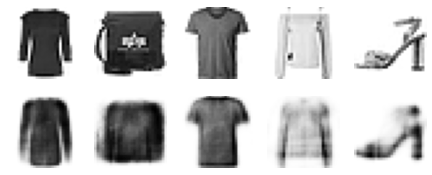

In [13]:
show_reconstructions(stacked_ae)

In [14]:
## Visualizing Fashion MNIST

In [15]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

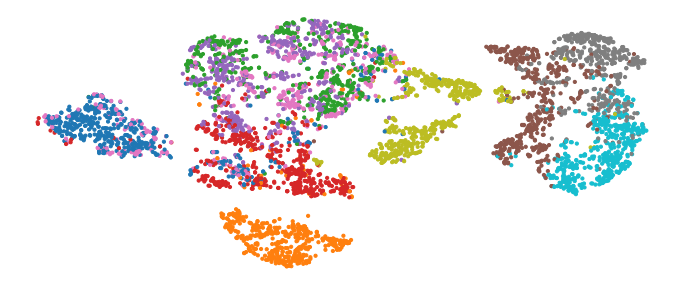

In [16]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

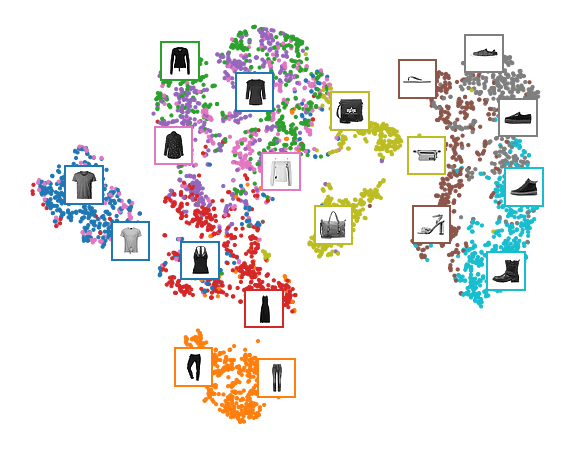

In [17]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## Using Convolutional Layers Instead of Dense Layers

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).



In [19]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 71s 1ms/sample - loss: 0.3020 - rounded_accuracy: 0.9186 - val_loss: 0.2801 - val_rounded_accuracy: 0.9394
Epoch 2/5
55000/55000 [==============================] - 70s 1ms/sample - loss: 0.2755 - rounded_accuracy: 0.9413 - val_loss: 0.2730 - val_rounded_accuracy: 0.9457
Epoch 3/5
55000/55000 [==============================] - 70s 1ms/sample - loss: 0.2707 - rounded_accuracy: 0.9463 - val_loss: 0.2706 - val_rounded_accuracy: 0.9472
Epoch 4/5
55000/55000 [==============================] - 69s 1ms/sample - loss: 0.2681 - rounded_accuracy: 0.9491 - val_loss: 0.2676 - val_rounded_accuracy: 0.9516
Epoch 5/5
55000/55000 [==============================] - 70s 1ms/sample - loss: 0.2663 - rounded_accuracy: 0.9510 - val_loss: 0.2660 - val_rounded_accuracy: 0.9534


In [20]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)         

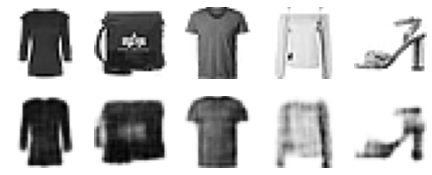

In [21]:
show_reconstructions(conv_ae)
plt.show()

## Stacked denoising Autoencoder
Using Gaussian noise:



In [22]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 15s 266us/sample - loss: 0.3494 - rounded_accuracy: 0.8779 - val_loss: 0.3163 - val_rounded_accuracy: 0.9075
Epoch 2/10
55000/55000 [==============================] - 14s 248us/sample - loss: 0.3120 - rounded_accuracy: 0.9097 - val_loss: 0.3086 - val_rounded_accuracy: 0.9126
Epoch 3/10
55000/55000 [==============================] - 14s 250us/sample - loss: 0.3060 - rounded_accuracy: 0.9149 - val_loss: 0.3047 - val_rounded_accuracy: 0.9150
Epoch 4/10
55000/55000 [==============================] - 14s 249us/sample - loss: 0.3023 - rounded_accuracy: 0.9181 - val_loss: 0.3002 - val_rounded_accuracy: 0.9219
Epoch 5/10
55000/55000 [==============================] - 14s 249us/sample - loss: 0.2996 - rounded_accuracy: 0.9205 - val_loss: 0.2976 - val_rounded_accuracy: 0.9247
Epoch 6/10
55000/55000 [==============================] - 14s 249us/sample - loss: 0.2977 - rounded_accuracy: 0.9222

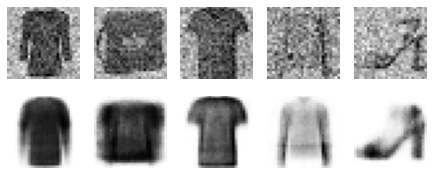

In [23]:

tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

Using dropout

In [24]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 15s 276us/sample - loss: 0.3554 - rounded_accuracy: 0.8721 - val_loss: 0.3188 - val_rounded_accuracy: 0.9057
Epoch 2/10
55000/55000 [==============================] - 14s 259us/sample - loss: 0.3179 - rounded_accuracy: 0.9034 - val_loss: 0.3115 - val_rounded_accuracy: 0.9117
Epoch 3/10
55000/55000 [==============================] - 14s 258us/sample - loss: 0.3124 - rounded_accuracy: 0.9078 - val_loss: 0.3070 - val_rounded_accuracy: 0.9144
Epoch 4/10
55000/55000 [==============================] - 14s 256us/sample - loss: 0.3089 - rounded_accuracy: 0.9106 - val_loss: 0.3039 - val_rounded_accuracy: 0.9173
Epoch 5/10
55000/55000 [==============================] - 14s 253us/sample - loss: 0.3065 - rounded_accuracy: 0.9126 - val_loss: 0.3016 - val_rounded_accuracy: 0.9198
Epoch 6/10
55000/55000 [==============================] - 14s 257us/sample - loss: 0.3047 - rounded_accuracy: 0.9141

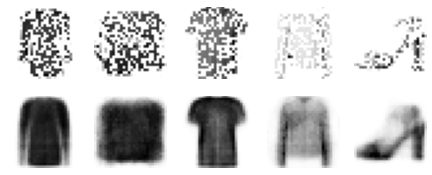

In [26]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
